In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

2022-11-08 14:19:38.696233: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-08 14:19:39.061750: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-08 14:19:40.064699: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-08 14:19:40.064857: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
n_channels = 16
alpha = 0.1

In [48]:
def load_image(filename):
    img = tf.keras.preprocessing.image.load_img(path=filename, color_mode='rgba', target_size=(64, 64))
    img = np.array(img) / 255.0

    # add transparency channel for black pixels
    img[img[:,:,2] < 0.1] = 0
    # add red border around the image
    img[0, :, 0] = 1
    img[-1, :, 0] = 1
    img[:, 0, 0] = 1
    img[:, -1, 0] = 1
    # set alpha channel to 1 for border pixels
    img[0, :, 3] = 1
    img[-1, :, 3] = 1
    img[:, 0, 3] = 1
    img[:, -1, 3] = 1
    
    chars = np.zeros((64, 64, 12), dtype=np.float32)
    img = np.append(img, chars, axis=2)
    img = tf.expand_dims(img, 0)
    return img

def rgba(x):
    return x[0, :, :, :4]

def rgb(x):
  rgb, a = x[0, :, :, :3], tf.clip_by_value(x[0, :, :, 3:4], 0.0, 1.0)
  return 1.0-a+rgb

def plot(x):
    plt.imshow(rgb(x))
    plt.show()

def save_plot(x, filename):
    plt.imshow(rgb(x))
    plt.savefig('.\Imgs\Epoch ' + str(filename) + '.png')

def get_living_mask(x):
    channel_alpha = x[:, :, :, 3:4]
    return tf.nn.max_pool2d(channel_alpha, 3, [1, 1, 1, 1], 'SAME') > alpha

In [4]:
class NNA(tf.keras.Model):

    def __init__(self, n_channels):
        super().__init__()
        self.channel_n = n_channels
        self.alpha = alpha

        self.dmodel = tf.keras.Sequential([
            tf.keras.layers.Conv2D(128, 1, activation=tf.nn.relu),
            tf.keras.layers.Conv2D(self.channel_n, 1, activation=None, kernel_initializer=tf.zeros_initializer)
        ])
        self(tf.zeros([1, 3, 3, n_channels]))

    def perceive(self, x):
        cellID = tf.constant([[0., 0., 0.], [0., 1., 0.], [0., 0., 0.]], dtype=tf.float32)
        sobelX = tf.constant([[-1., 0., 1.], [-2., 0., 2.], [-1., 0., 1.]], dtype=tf.float32)
        sobelY = tf.constant([[-1., -2., -1.], [0., 0., 0.], [1., 2., 1.]], dtype=tf.float32)

        kernel = tf.stack([cellID, sobelX, sobelY], -1)[:, :, None, :]
        kernel = tf.repeat(kernel, self.channel_n, 2)

        y = tf.nn.depthwise_conv2d(x, kernel, [1, 1, 1, 1], 'SAME')
        return y

    def call(self, x, steps = 1):
        pre_live_mask = get_living_mask(x)

        y = self.perceive(x)
        dx = self.dmodel(y) * steps

        update_mask = tf.random.uniform(tf.shape(x[:, :, :, :1])) <= 0.5
        x += dx * tf.cast(update_mask, tf.float32)

        post_life_mask = get_living_mask(x)
        life_mask = pre_live_mask & post_life_mask
        return x * tf.cast(life_mask, tf.float32)

In [5]:
model = NNA(n_channels)

2022-11-08 14:20:01.967127: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-08 14:20:02.011380: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-11-08 14:20:02.011401: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-11-08 14:20:02.011787: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

In [6]:
lr = 2e-3
lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay([5000], [lr, lr*0.05])
optimizer = tf.keras.optimizers.Adam(lr_sched)
loss_object = tf.keras.losses.MeanSquaredError()

In [70]:
anim = []
anim_len = 500

for i in range(anim_len):
    anim.append(load_image('../data/export/frame_' + f'{i:05d}' + '.png'))

    

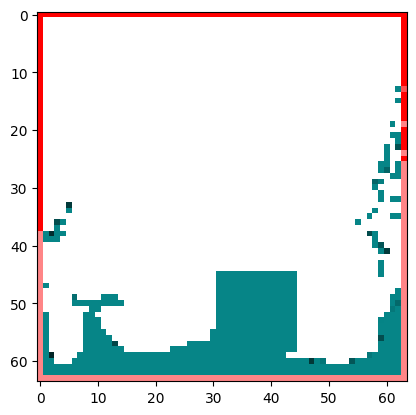

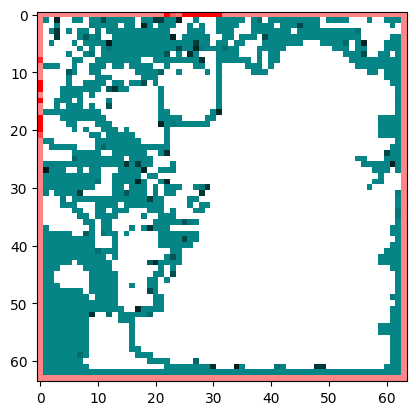

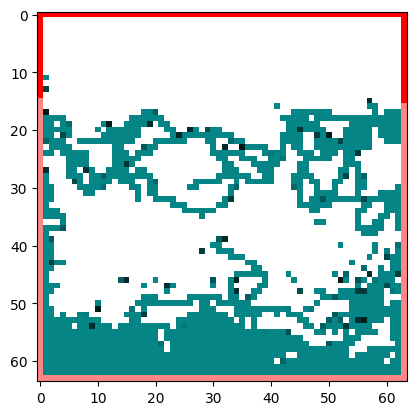

In [71]:
plot(anim[int(anim_len*0.2)])
plot(anim[int(anim_len*0.4)])
plot(anim[int(anim_len*0.6)])

In [66]:
def loss_f(i, x):
    return loss_object(rgba(anim[i]), rgba(x))

def train_step(x):
    n = tf.random.uniform([],64,96,tf.int32)
    print('n', n)
    with tf.GradientTape() as g:
        # not sure this is correct
        for i in tf.range(n):
            x = model(x)
            loss = loss_f(i, x) * 100
        gradients = g.gradient(loss, model.weights)
        gradients = [g / (tf.norm(g) + 1e-8) for g in gradients]
        optimizer.apply_gradients(zip(gradients, model.weights))
    return x, loss

In [67]:
def init_image():
    return anim[0]

In [68]:
x0 = init_image()

n tf.Tensor(85, shape=(), dtype=int32)
Epoch 1, Loss: 378.1181640625


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


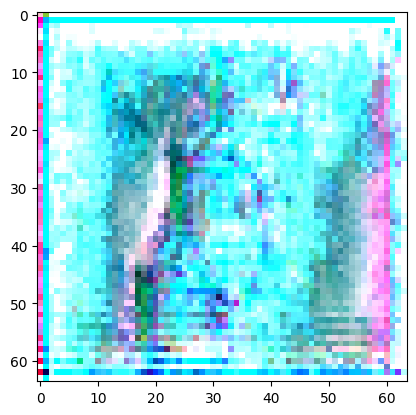

n tf.Tensor(93, shape=(), dtype=int32)
Epoch 2, Loss: 157.71119689941406
n tf.Tensor(87, shape=(), dtype=int32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 3, Loss: 41.72172927856445


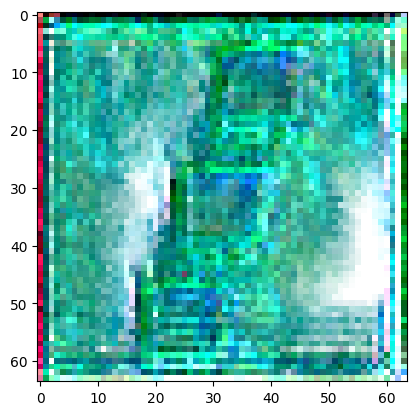

n tf.Tensor(94, shape=(), dtype=int32)
Epoch 4, Loss: 20.72984504699707
n tf.Tensor(93, shape=(), dtype=int32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 5, Loss: 10.364224433898926


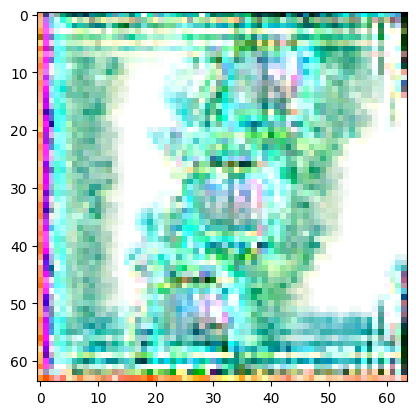

n tf.Tensor(88, shape=(), dtype=int32)
Epoch 6, Loss: 8.838383674621582
n tf.Tensor(89, shape=(), dtype=int32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 7, Loss: 8.253613471984863


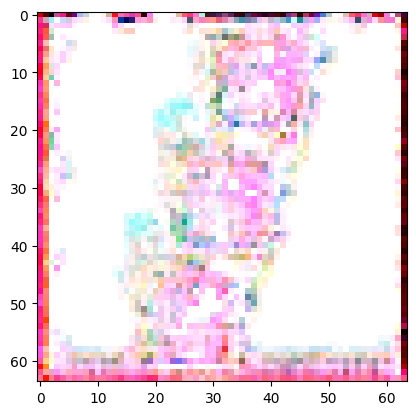

n tf.Tensor(76, shape=(), dtype=int32)
Epoch 8, Loss: 6.4579854011535645
n tf.Tensor(87, shape=(), dtype=int32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 9, Loss: 7.267682075500488


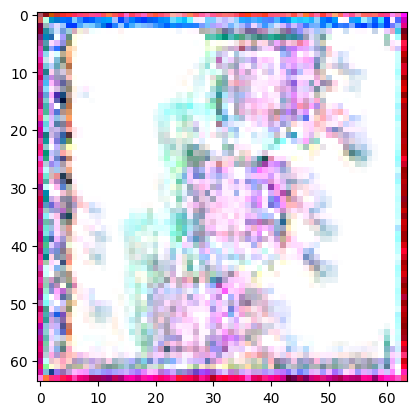

n tf.Tensor(79, shape=(), dtype=int32)
Epoch 10, Loss: 5.166228771209717
n tf.Tensor(71, shape=(), dtype=int32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 11, Loss: 4.468416690826416


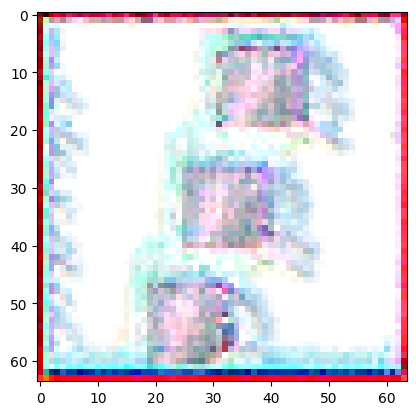

n tf.Tensor(71, shape=(), dtype=int32)
Epoch 12, Loss: 3.975318431854248
n tf.Tensor(92, shape=(), dtype=int32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 13, Loss: 5.379868030548096


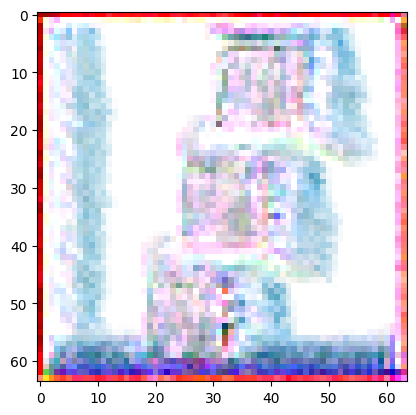

n tf.Tensor(91, shape=(), dtype=int32)
Epoch 14, Loss: 4.432291507720947
n tf.Tensor(94, shape=(), dtype=int32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 15, Loss: 4.431187629699707


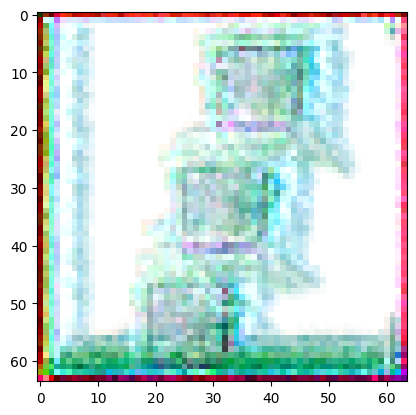

n tf.Tensor(64, shape=(), dtype=int32)
Epoch 16, Loss: 4.198298454284668
n tf.Tensor(90, shape=(), dtype=int32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 17, Loss: 4.590573310852051


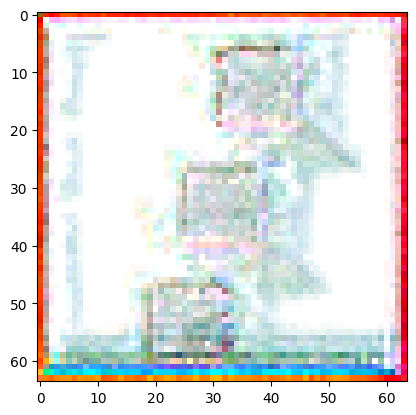

n tf.Tensor(88, shape=(), dtype=int32)
Epoch 18, Loss: 4.160965919494629
n tf.Tensor(78, shape=(), dtype=int32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 19, Loss: 3.4338276386260986


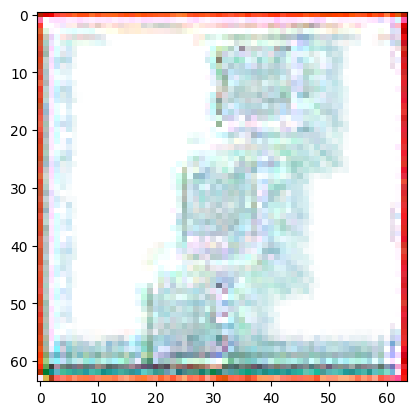

n tf.Tensor(83, shape=(), dtype=int32)
Epoch 20, Loss: 3.7373311519622803
n tf.Tensor(77, shape=(), dtype=int32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 21, Loss: 3.2065863609313965


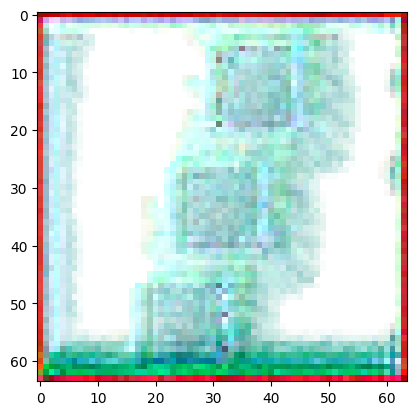

n tf.Tensor(76, shape=(), dtype=int32)
Epoch 22, Loss: 3.020045518875122
n tf.Tensor(73, shape=(), dtype=int32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 23, Loss: 2.9868674278259277


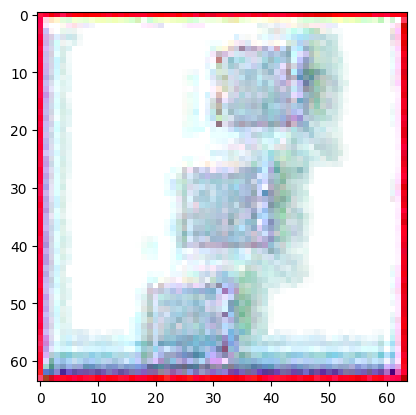

n tf.Tensor(70, shape=(), dtype=int32)
Epoch 24, Loss: 3.0905940532684326
n tf.Tensor(77, shape=(), dtype=int32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 25, Loss: 2.6194260120391846


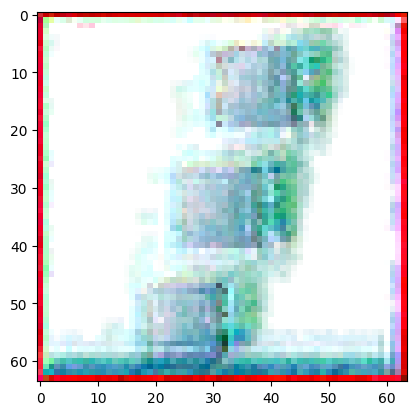

n tf.Tensor(84, shape=(), dtype=int32)
Epoch 26, Loss: 3.1120240688323975
n tf.Tensor(68, shape=(), dtype=int32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 27, Loss: 3.0958051681518555


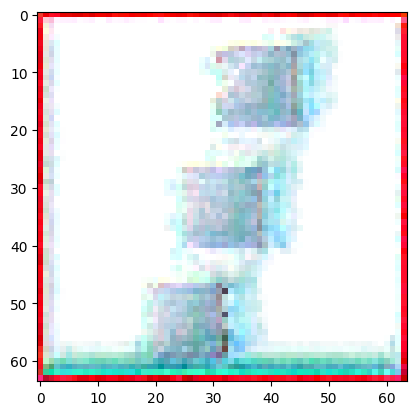

n tf.Tensor(91, shape=(), dtype=int32)
Epoch 28, Loss: 3.6689839363098145
n tf.Tensor(79, shape=(), dtype=int32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 29, Loss: 2.5854599475860596


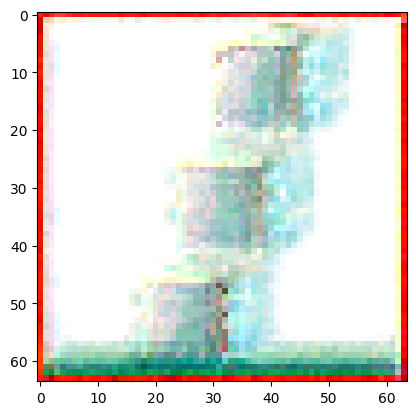

n tf.Tensor(81, shape=(), dtype=int32)
Epoch 30, Loss: 2.713597536087036
n tf.Tensor(75, shape=(), dtype=int32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 31, Loss: 2.5183017253875732


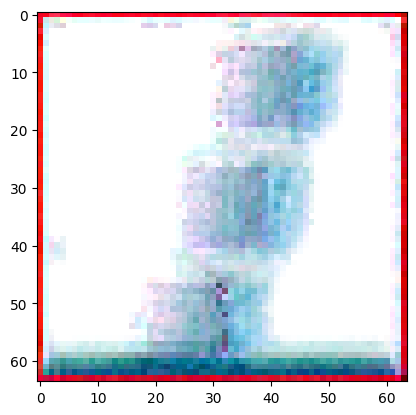

n tf.Tensor(86, shape=(), dtype=int32)
Epoch 32, Loss: 2.8498284816741943
n tf.Tensor(82, shape=(), dtype=int32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 33, Loss: 2.363124370574951


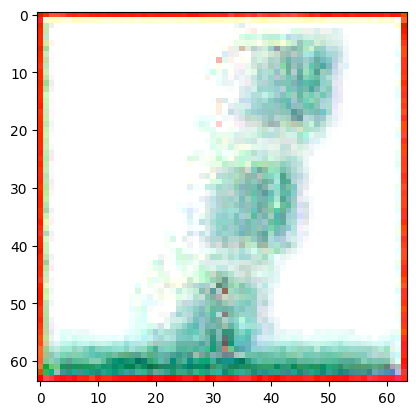

n tf.Tensor(91, shape=(), dtype=int32)
Epoch 34, Loss: 3.2706828117370605
n tf.Tensor(76, shape=(), dtype=int32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 35, Loss: 2.430511951446533


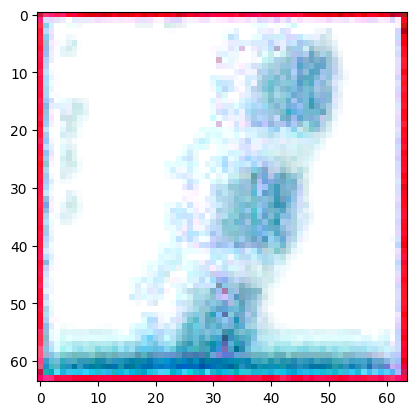

n tf.Tensor(88, shape=(), dtype=int32)
Epoch 36, Loss: 2.6791858673095703
n tf.Tensor(67, shape=(), dtype=int32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 37, Loss: 3.165952205657959


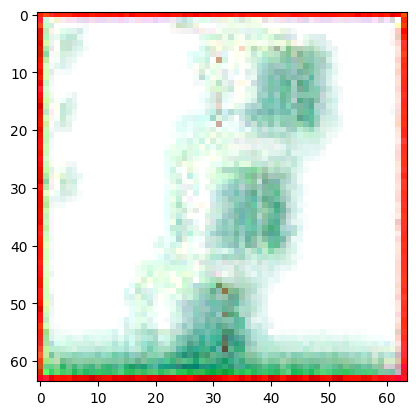

n tf.Tensor(76, shape=(), dtype=int32)
Epoch 38, Loss: 2.272512197494507
n tf.Tensor(82, shape=(), dtype=int32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 39, Loss: 2.697709083557129


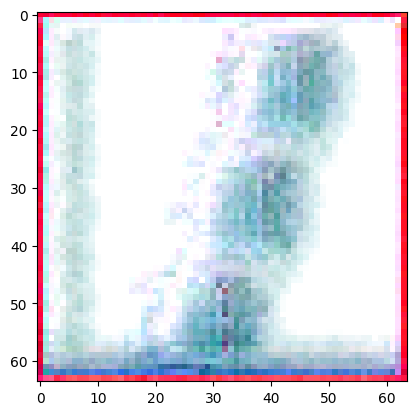

n tf.Tensor(95, shape=(), dtype=int32)
Epoch 40, Loss: 3.561863422393799
n tf.Tensor(92, shape=(), dtype=int32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 41, Loss: 2.9379465579986572


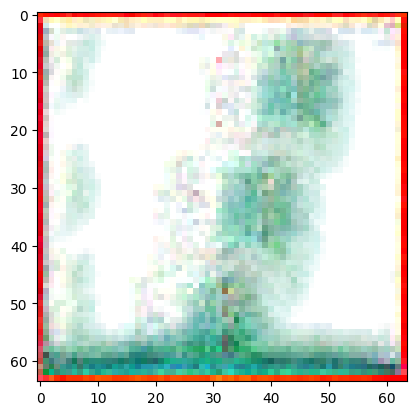

n tf.Tensor(74, shape=(), dtype=int32)
Epoch 42, Loss: 2.532121181488037
n tf.Tensor(66, shape=(), dtype=int32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 43, Loss: 2.94978666305542


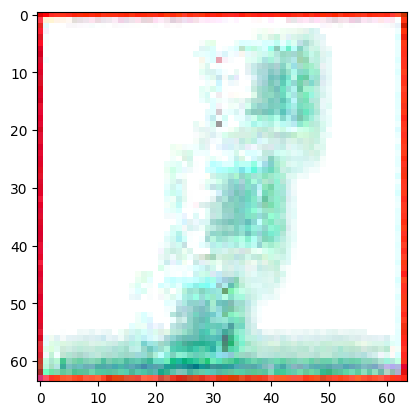

n tf.Tensor(64, shape=(), dtype=int32)
Epoch 44, Loss: 2.9750030040740967
n tf.Tensor(67, shape=(), dtype=int32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 45, Loss: 2.5638551712036133


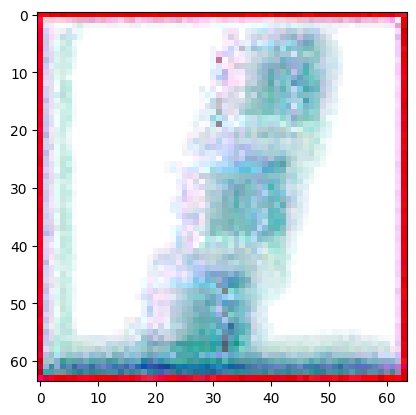

n tf.Tensor(75, shape=(), dtype=int32)
Epoch 46, Loss: 2.381890296936035
n tf.Tensor(93, shape=(), dtype=int32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 47, Loss: 3.617642879486084


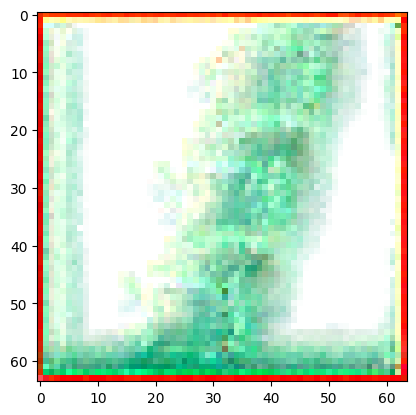

n tf.Tensor(81, shape=(), dtype=int32)
Epoch 48, Loss: 2.5871238708496094
n tf.Tensor(73, shape=(), dtype=int32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 49, Loss: 2.1165106296539307


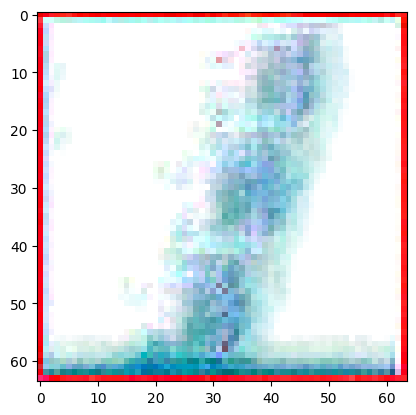

n tf.Tensor(82, shape=(), dtype=int32)
Epoch 50, Loss: 2.519779920578003
n tf.Tensor(76, shape=(), dtype=int32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 51, Loss: 2.0233869552612305


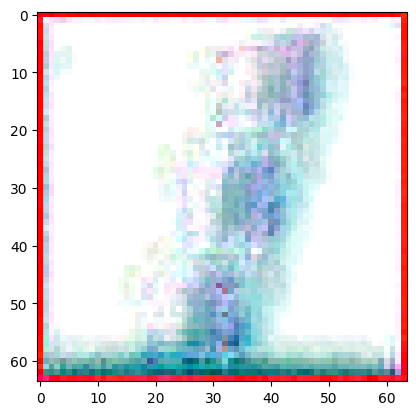

n tf.Tensor(88, shape=(), dtype=int32)
Epoch 52, Loss: 2.6771557331085205
n tf.Tensor(66, shape=(), dtype=int32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 53, Loss: 2.2316744327545166


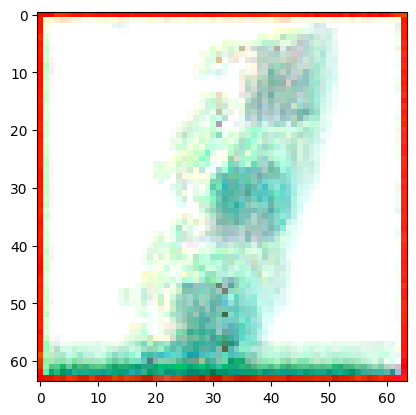

n tf.Tensor(69, shape=(), dtype=int32)
Epoch 54, Loss: 1.8516185283660889
n tf.Tensor(93, shape=(), dtype=int32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 55, Loss: 3.0672221183776855


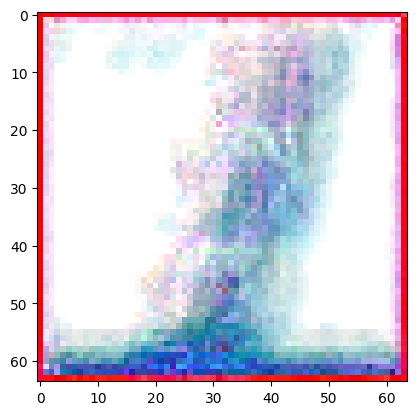

n tf.Tensor(90, shape=(), dtype=int32)
Epoch 56, Loss: 2.6501762866973877
n tf.Tensor(81, shape=(), dtype=int32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 57, Loss: 1.9178993701934814


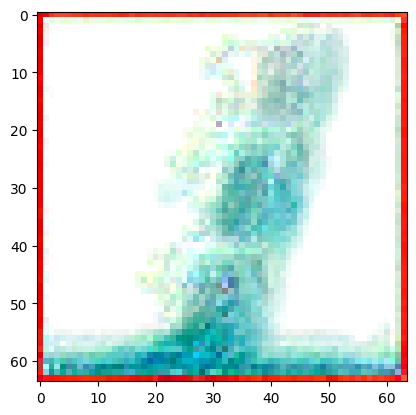

n tf.Tensor(94, shape=(), dtype=int32)
Epoch 58, Loss: 2.5972936153411865
n tf.Tensor(91, shape=(), dtype=int32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 59, Loss: 2.2006773948669434


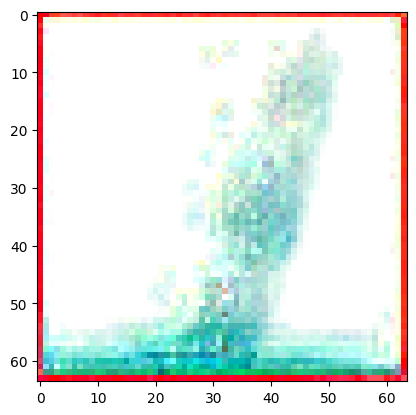

n tf.Tensor(71, shape=(), dtype=int32)
Epoch 60, Loss: 2.1320223808288574
n tf.Tensor(68, shape=(), dtype=int32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 61, Loss: 2.3088064193725586


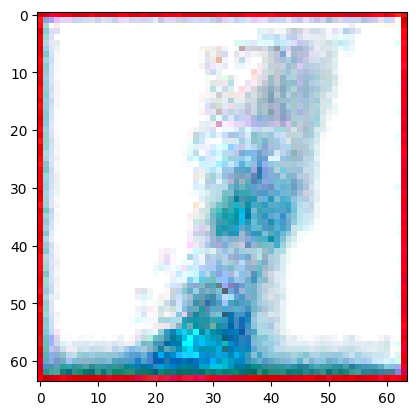

n tf.Tensor(84, shape=(), dtype=int32)
Epoch 62, Loss: 2.063509464263916
n tf.Tensor(93, shape=(), dtype=int32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 63, Loss: 2.3568761348724365


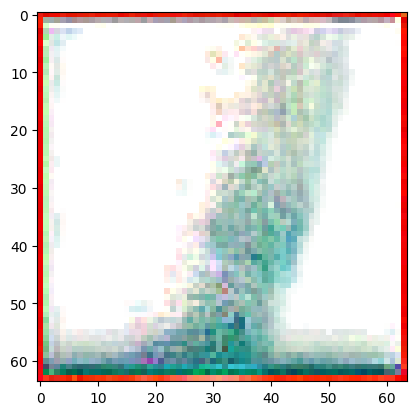

n tf.Tensor(92, shape=(), dtype=int32)
Epoch 64, Loss: 2.3198556900024414
n tf.Tensor(94, shape=(), dtype=int32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 65, Loss: 2.3967766761779785


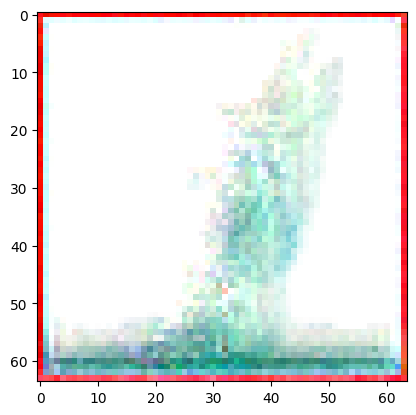

n tf.Tensor(83, shape=(), dtype=int32)
Epoch 66, Loss: 1.9777711629867554
n tf.Tensor(75, shape=(), dtype=int32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 67, Loss: 2.312549114227295


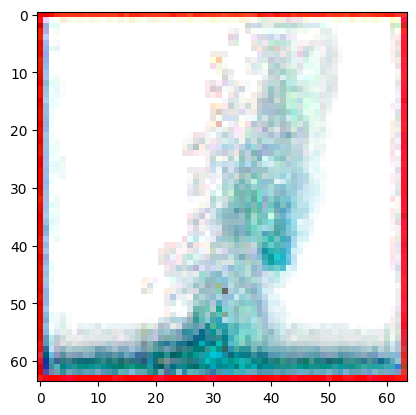

n tf.Tensor(93, shape=(), dtype=int32)
Epoch 68, Loss: 2.341115951538086
n tf.Tensor(66, shape=(), dtype=int32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 69, Loss: 2.238924026489258


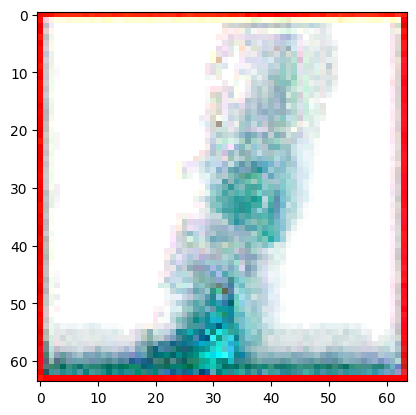

n tf.Tensor(67, shape=(), dtype=int32)
Epoch 70, Loss: 1.9380053281784058
n tf.Tensor(67, shape=(), dtype=int32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 71, Loss: 1.7480154037475586


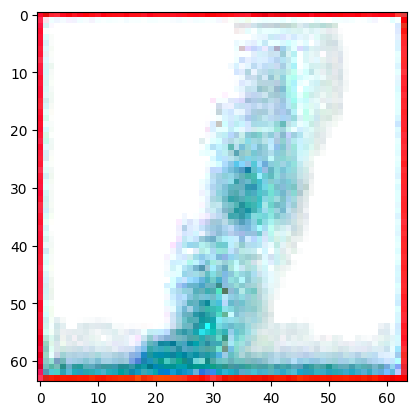

n tf.Tensor(74, shape=(), dtype=int32)
Epoch 72, Loss: 1.8001762628555298
n tf.Tensor(85, shape=(), dtype=int32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 73, Loss: 2.6611876487731934


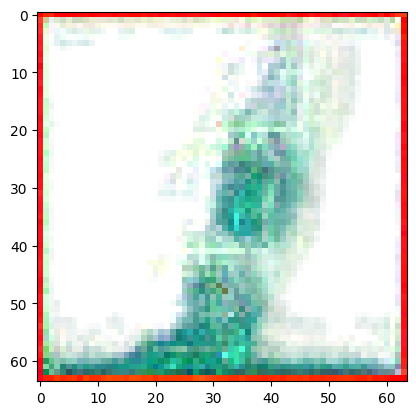

n tf.Tensor(80, shape=(), dtype=int32)
Epoch 74, Loss: 2.2309882640838623
n tf.Tensor(80, shape=(), dtype=int32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 75, Loss: 1.9681040048599243


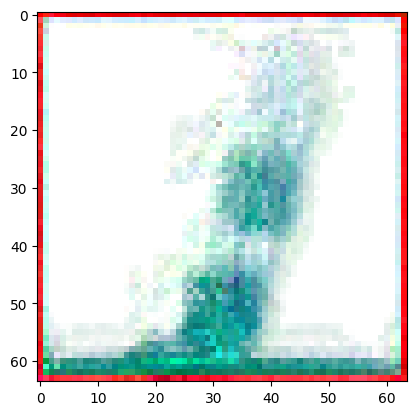

n tf.Tensor(83, shape=(), dtype=int32)
Epoch 76, Loss: 1.9319534301757812
n tf.Tensor(90, shape=(), dtype=int32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 77, Loss: 2.2357444763183594


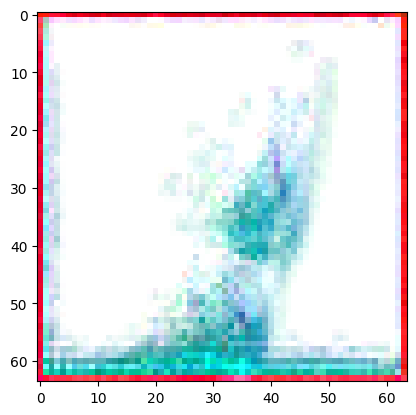

n tf.Tensor(89, shape=(), dtype=int32)
Epoch 78, Loss: 2.189812421798706
n tf.Tensor(64, shape=(), dtype=int32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 79, Loss: 2.678961992263794


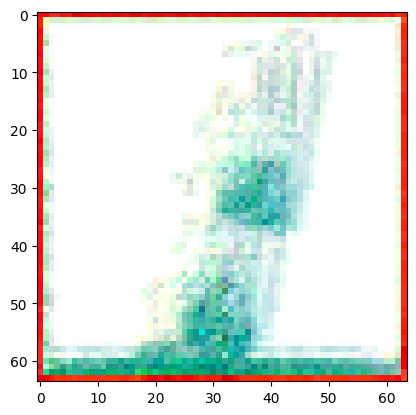

n tf.Tensor(67, shape=(), dtype=int32)
Epoch 80, Loss: 2.5142621994018555
n tf.Tensor(80, shape=(), dtype=int32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 81, Loss: 1.7504013776779175


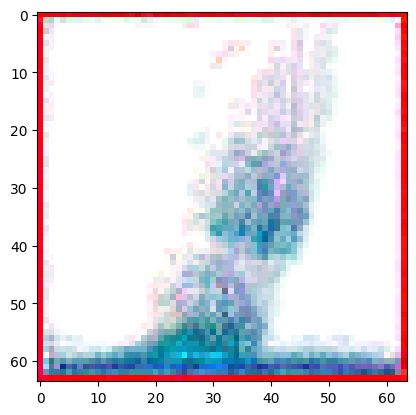

n tf.Tensor(82, shape=(), dtype=int32)
Epoch 82, Loss: 1.7938666343688965
n tf.Tensor(92, shape=(), dtype=int32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 83, Loss: 2.8449573516845703


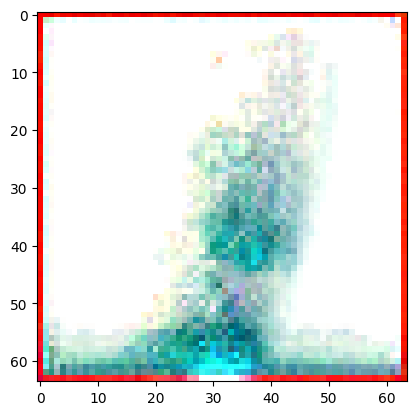

n tf.Tensor(94, shape=(), dtype=int32)
Epoch 84, Loss: 2.6044182777404785
n tf.Tensor(91, shape=(), dtype=int32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 85, Loss: 2.4006247520446777


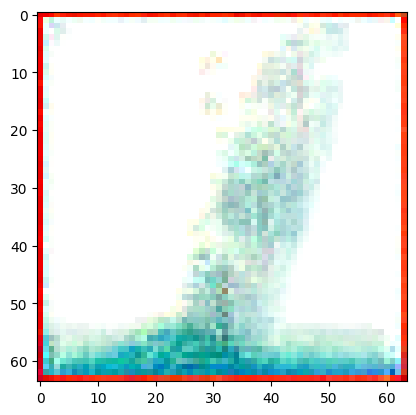

n tf.Tensor(92, shape=(), dtype=int32)
Epoch 86, Loss: 2.3770997524261475
n tf.Tensor(84, shape=(), dtype=int32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 87, Loss: 2.1782736778259277


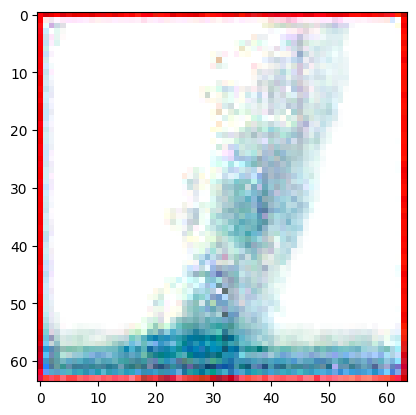

n tf.Tensor(86, shape=(), dtype=int32)
Epoch 88, Loss: 2.1310572624206543
n tf.Tensor(95, shape=(), dtype=int32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 89, Loss: 2.534752607345581


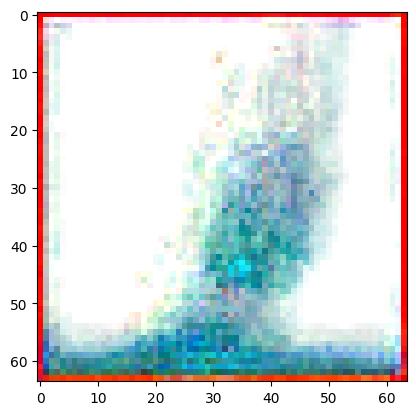

n tf.Tensor(68, shape=(), dtype=int32)
Epoch 90, Loss: 2.410055637359619
n tf.Tensor(80, shape=(), dtype=int32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 91, Loss: 1.790743350982666


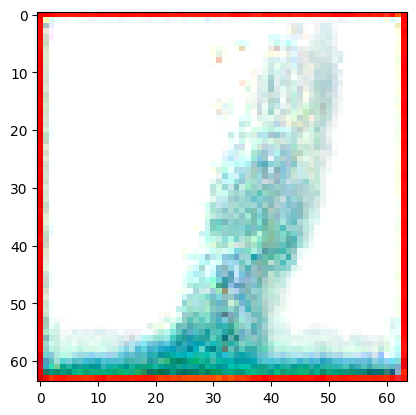

n tf.Tensor(86, shape=(), dtype=int32)
Epoch 92, Loss: 1.8794564008712769
n tf.Tensor(87, shape=(), dtype=int32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 93, Loss: 1.8628616333007812


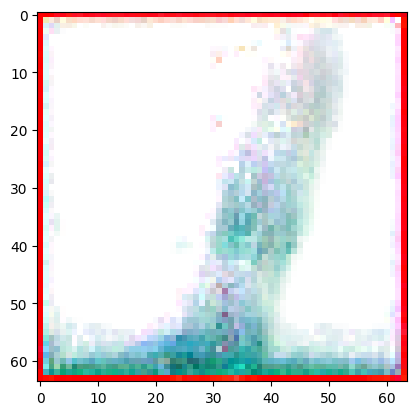

n tf.Tensor(82, shape=(), dtype=int32)
Epoch 94, Loss: 1.7362562417984009
n tf.Tensor(78, shape=(), dtype=int32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 95, Loss: 1.653620958328247


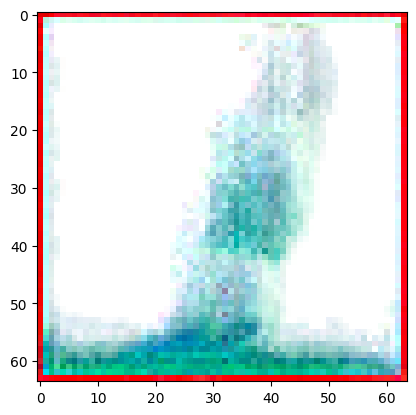

n tf.Tensor(69, shape=(), dtype=int32)
Epoch 96, Loss: 1.8034954071044922
n tf.Tensor(84, shape=(), dtype=int32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 97, Loss: 1.9249897003173828


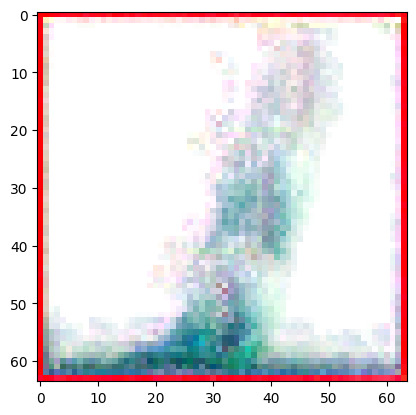

n tf.Tensor(91, shape=(), dtype=int32)
Epoch 98, Loss: 2.302797555923462
n tf.Tensor(92, shape=(), dtype=int32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 99, Loss: 2.735106945037842


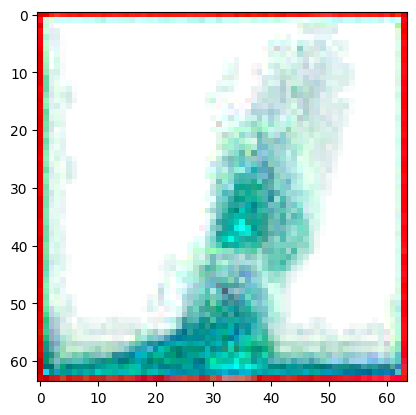

n tf.Tensor(92, shape=(), dtype=int32)
Epoch 100, Loss: 2.3349578380584717


In [69]:
EPOCHS = 100
for epoch in range(EPOCHS):
    x, loss = train_step(x0)
    template = 'Epoch {}, Loss: {}'
    print(template.format(epoch + 1, loss))

    if epoch % 2 == 0:
        plot(x)

In [14]:
model.save("testModel")

INFO:tensorflow:Assets written to: testModel/assets


INFO:tensorflow:Assets written to: testModel/assets


In [15]:
#@title TensorFlow.js Demo {run:"auto", vertical-output: true}
#@markdown Select "CHECKPOINT" model to load the checkpoint created by running cells from the "Training" section of this notebook
import IPython.display

data_js = '''
  window.GRAPH_URL = URL.createObjectURL(new Blob([`%s`], {type: 'application/json'}));
'''%(model)

display(IPython.display.Javascript(data_js))

IPython.display.HTML('''
<script src="https://cdn.jsdelivr.net/npm/@tensorflow/tfjs@2.3.0/dist/tf.min.js"></script>

<canvas id='canvas' style="border: 1px solid black; image-rendering: pixelated;"></canvas>

<script>
  "use strict";
  
  const sleep = (ms)=>new Promise(resolve => setTimeout(resolve, ms));

  const parseConsts = model_graph=>{
    const dtypes = {'DT_INT32':['int32', 'intVal', Int32Array],
                    'DT_FLOAT':['float32', 'floatVal', Float32Array]};
    
    const consts = {};
    model_graph.modelTopology.node.filter(n=>n.op=='Const').forEach((node=>{
      const v = node.attr.value.tensor;
      const [dtype, field, arrayType] = dtypes[v.dtype];
      if (!v.tensorShape.dim) {
        consts[node.name] = [tf.scalar(v[field][0], dtype)];
      } else {
        // if there is a 0-length dimension, the exported graph json lacks "size"
        const shape = v.tensorShape.dim.map(d=>(!d.size) ? 0 : parseInt(d.size));
        let arr;
        if (v.tensorContent) {
          const data = atob(v.tensorContent);
          const buf = new Uint8Array(data.length);
          for (var i=0; i<data.length; ++i) {
            buf[i] = data.charCodeAt(i);
          }
          arr = new arrayType(buf.buffer);
        } else {
          const size = shape.reduce((a, b)=>a*b);
          arr = new arrayType(size);
          if (size) {
            arr.fill(v[field][0]);
          }
        }
        consts[node.name] = [tf.tensor(arr, shape, dtype)];
      }
    }));
    return consts;
  }
  
  const run = async ()=>{
    const r = await fetch(GRAPH_URL);
    const consts = parseConsts(await r.json());
    
    const model = await tf.loadGraphModel(GRAPH_URL);
    Object.assign(model.weights, consts);
    
    let seed = new Array(16).fill(0).map((x, i)=>i<3?0:1);
    seed = tf.tensor(seed, [1, 1, 1, 16]);
    
    const D = 96;
    const initState = tf.tidy(()=>{
      const D2 = D/2;
      const a = seed.pad([[0, 0], [D2-1, D2], [D2-1, D2], [0,0]]);
      return a;
    });
    
    const state = tf.variable(initState);
    const [_, h, w, ch] = state.shape;
    
    const damage = (x, y, r)=>{
      tf.tidy(()=>{
        const rx = tf.range(0, w).sub(x).div(r).square().expandDims(0);
        const ry = tf.range(0, h).sub(y).div(r).square().expandDims(1);
        const mask = rx.add(ry).greater(1.0).expandDims(2);
        state.assign(state.mul(mask));
      });
    }
    
    const plantSeed = (x, y)=>{
      const x2 = w-x-seed.shape[2];
      const y2 = h-y-seed.shape[1];
      if (x<0 || x2<0 || y2<0 || y2<0)
        return;
      tf.tidy(()=>{
        const a = seed.pad([[0, 0], [y, y2], [x, x2], [0,0]]);
        state.assign(state.add(a));
      });
    }
    
    const scale = 4;
    
    const canvas = document.getElementById('canvas');
    const ctx = canvas.getContext('2d');
    canvas.width = w;
    canvas.height = h;
    canvas.style.width = `${w*scale}px`;
    canvas.style.height = `${h*scale}px`;
    
    canvas.onmousedown = e=>{
      const x = Math.floor(e.clientX/scale);
        const y = Math.floor(e.clientY/scale);
        if (e.buttons == 1) {
          if (e.shiftKey) {
            plantSeed(x, y);  
          } else {
            damage(x, y, 8);
          }
        }
    }
    canvas.onmousemove = e=>{
      const x = Math.floor(e.clientX/scale);
      const y = Math.floor(e.clientY/scale);
      if (e.buttons == 1 && !e.shiftKey) {
        damage(x, y, 8);
      }
    }

    function step() {
      tf.tidy(()=>{
        state.assign(model.execute(
            {x:state, fire_rate:tf.tensor(0.5),
            angle:tf.tensor(0.0), step_size:tf.tensor(1.0)}, ['Identity']));
      });
    }

    function render() {
      step();

      const imageData = tf.tidy(()=>{
        const rgba = state.slice([0, 0, 0, 0], [-1, -1, -1, 4]);
        const a = state.slice([0, 0, 0, 3], [-1, -1, -1, 1]);
        const img = tf.tensor(1.0).sub(a).add(rgba).mul(255);
        const rgbaBytes = new Uint8ClampedArray(img.dataSync());
        return new ImageData(rgbaBytes, w, h);
      });
      ctx.putImageData(imageData, 0, 0);

      requestAnimationFrame(render);
    }
    render();
  }
  run();
  
</script>
''')

<IPython.core.display.Javascript object>